
# Pakistan's Largest E-Commerce Dataset 
datset link: https://www.kaggle.com/datasets/zusmani/pakistans-largest-ecommerce-dataset 

The typical Machine Learning pipeline includes the following: 

1. Data Preparation - obtaining and loading the data.
2. Data Preprocessing - cleaning the data (missing values, etc).
3. Exploratory Data Analysis (EDA) - generating summaries and utilizing other statistical methods, and visualizing the data. 
4. Data Processing - feature selection/extraction and feature engineering.
5. Building a Model - splitting data into training and testing sets (holdout - optional), and training and testing chosen machine learning algorithms.
6. Model Evaluation - choosing metrics, applying metrics on predictions on the testing set, selecting the best model in your opinion.

In [2]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 199 kB 45.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d8803d8891c0c3f8dde0fe0f8c3a7bfd94283b65f9a993c23980acc92504438e
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [3]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Connect to the Spark server

We will be using the SparkSession (`spark`) to access our spark cluster..

In [4]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()


## 1. Data Preparation

The data has been made available to us in the `data` directory

In [6]:
fullpath = '/content/drive/MyDrive/Colab Notebooks/Big_data/w10/day_2/Pakistan Largest Ecommerce Dataset.csv'

data = spark.read.csv(fullpath)

In [7]:
data

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string]

As can be seen above, the data do not contain column headings so we will have to add those. 

When we import the data below, the schema (which is similar to a schema in SQL or dtypes in Pandas) has been inferred based on the data.

In [8]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- sku: string (nullable = true)
 |-- price: double (nullable = true)
 |-- qty_ordered: integer (nullable = true)
 |-- grand_total: double (nullable = true)
 |-- increment_id: string (nullable = true)
 |-- category_name_1: string (nullable = true)
 |-- sales_commission_code: string (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- Working Date: string (nullable = true)
 |-- BI Status: string (nullable = true)
 |--  MV : string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Customer Since: string (nullable = true)
 |-- M-Y: string (nullable = true)
 |-- FY: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string

## 2. Data Preprocessing

"url", "region_url", "image_url", "description" columns are unnecessary. let's drop them

In [23]:
#check the content of the column 
data.select("_c21").show(10)


+----+
|_c21|
+----+
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
+----+
only showing top 10 rows



In [24]:
# these columns are useless to us, drop them
drop_cols = ['item_id', 'created_at', 'increment_id', 'sales_commission_code','_c21','_c22','_c23','_c24','_c25']

data = data.drop(*drop_cols)

In [28]:
#data.filter(data("status").isNull).show(false)


Some categorical columns have own null indicators like "other" and "missing", set them null



In [ ]:
# both null values and null indicators(other) exist, set the indicator to null (to prevent confusion)
data = data.replace('other', None, subset=['cylinders'])

In [ ]:
# both null values and null indicators(missing) exist, set the indicator to null (to prevent confusion)
data = data.replace('missing', None, subset=['title_status'])

It seems pyspark interpreted "lat" and "long" columns as string. We should clean these columns from alphabetic characters. And we should check the numeric range of "lat" and "long" columns.


In [ ]:
# Latitude should be between (-90, 90), otherwise set null
data = data.withColumn('lat', F.when(F.col('lat').rlike('^-?\d+\.?\d+$'), F.col('lat')))
data = data.withColumn('lat', F.col('lat').cast(types.FloatType()))
data = data.withColumn('lat', F.when((-90 <= F.col('lat')) & (F.col('lat') <= 90), F.col('lat')))

In [ ]:
# Longitude should be between (-180, 180), otherwise set null
data = data.withColumn('long', F.when(F.col('long').rlike('^-?\d+\.?\d+$'), F.col('long')))
data = data.withColumn('long', F.col('long').cast(types.FloatType()))
data = data.withColumn('long', F.when((-180 <= F.col('long')) & (F.col('long') <= 180), F.col('long')))

In [ ]:
# Posting date should be in format yyyy-MM-dd HH:mm:ss.SSSS
data = data.withColumn('posting_date', F.when(F.col('posting_date').rlike('^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'), F.col('posting_date')))
data = data.withColumn('posting_date', F.col('posting_date').cast(types.TimestampType()))

### Descriptive Statistics
Hint: If data is too big you can sample it before the descriptive statistics calculations.

We will get descriptive statistics for price, year, and odometer (mileage) to see how these data are distributed.

In [ ]:
data.select('price', 'year', 'odometer').summary().show()

+-------+-------------------+------------------+------------------+
|summary|              price|              year|          odometer|
+-------+-------------------+------------------+------------------+
|  count|             426582|            425377|            422182|
|   mean|  75240.00097753773|2011.2356544900172|  98019.2444514451|
| stddev|1.218653645968038E7|   9.4529441236719|213407.41232087038|
|    min|                  0|              1900|                 0|
|    25%|               5900|              2008|             37675|
|    50%|              13950|              2013|             85519|
|    75%|              26455|              2017|            133538|
|    max|         3736928711|              2022|          10000000|
+-------+-------------------+------------------+------------------+



### Data Wrangling
"price" and "odometer" columns have right skewed distribution (mean is bigger than median). Both these columns have huge numbers and huge standard deviation, so we can take the log of them to make it easier to analyze.

In [ ]:
# both columns starts with 0, log(0) is undefined so we should put +1
data = data.withColumn('price', F.log10(F.col('price') + 1))
data = data.withColumn('odometer', F.log10(F.col('odometer') + 1))

In [ ]:
data.select('price', 'year', 'odometer').summary().show()

+-------+------------------+------------------+------------------+
|summary|             price|              year|          odometer|
+-------+------------------+------------------+------------------+
|  count|            426582|            425377|            422182|
|   mean|3.7736931253525903|2011.2356544900172| 4.745384684351896|
| stddev|1.2051273580604176|   9.4529441236719|0.7163314827973487|
|    min|               0.0|              1900|               0.0|
|    25%|3.7709256146389993|              2008| 4.576064788225377|
|    50%| 4.144605338714745|              2013| 4.932067692200722|
|    75%| 4.422524181905646|              2017|5.1256081197175325|
|    max| 9.572514813054259|              2022| 7.000000043429446|
+-------+------------------+------------------+------------------+



Also, we can split the "posting_date" column (datatype: timestamp) into "posting_year" and "posting month" (datatype: integer) to make them easier to analyze.

In [ ]:
# date column to year and month columns
data = data.withColumn('posting_year', F.year(F.col('posting_date')))
data = data.withColumn('posting_month', F.month(F.col('posting_date')))

data = data.drop('posting_date')

## Data Exploration

Spark SQL allows us to explore data using SQL syntax. Let's examine the breakdown of cars by state. To perform SQL queries, the tables have to be registered using the `registerTempTable` method.

In [ ]:
data.registerTempTable('data')

state_counts = spark.sql(r"""SELECT state, COUNT(state) AS total 
                                     FROM data 
                                     GROUP BY state 
                                     ORDER BY total desc """)
state_counts.show()

+-----+-----+
|state|total|
+-----+-----+
|   ca|44223|
|   fl|25601|
|   tx|20259|
|   ny|17731|
|   oh|16060|
|   mi|14957|
|   or|13425|
|   pa|12640|
|   nc|12223|
|   wi|10289|
|   il| 9615|
|   tn| 9543|
|   nj| 9429|
|   co| 9175|
|   va| 8954|
|   wa| 7679|
|   az| 7490|
|   ma| 7464|
|   ia| 7321|
|   mn| 6981|
+-----+-----+
only showing top 20 rows



California (CA) has the most number of used cars available for sale, followed by Florida (FL) and Texas (TX).

Now, lets have a look at the cars by manufacturer.

In [ ]:
mfr_counts = spark.sql(r"""SELECT manufacturer, COUNT(manufacturer) as total
                                  FROM data
                                  GROUP BY manufacturer
                                  ORDER BY total desc""")

mfr_counts.show()

+-------------+-----+
| manufacturer|total|
+-------------+-----+
|         ford|70934|
|    chevrolet|55023|
|       toyota|34177|
|        honda|21257|
|       nissan|19055|
|         jeep|19003|
|          ram|18327|
|          gmc|16760|
|          bmw|14684|
|        dodge|13703|
|mercedes-benz|11808|
|      hyundai|10335|
|       subaru| 9494|
|   volkswagen| 9342|
|          kia| 8452|
|        lexus| 8190|
|         audi| 7564|
|     cadillac| 6950|
|     chrysler| 6026|
|        acura| 5977|
+-------------+-----+
only showing top 20 rows



We can see that Ford, Chevrolet, and Toyota are top three in terms of the amount of used cars for sale.

### Histogram

Lets try to visualize the manufacturers with most number of used cars for sale using a Histogram.

In [ ]:
#top three manufacturers
df_result = spark.sql('SELECT manufacturer, price FROM data WHERE manufacturer IN ("chevrolet", "ford", "toyota")')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

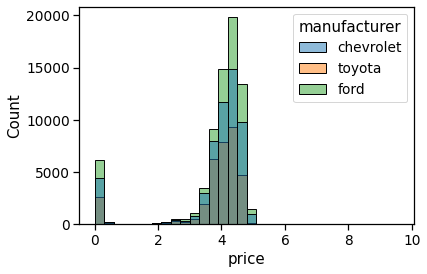

In [ ]:
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_result, x='price', hue='manufacturer', binwidth=0.3)

### Scatter Plot

Lets try to see the distribution of all conditions in terms of price and odometer.

In [ ]:
df_result = spark.sql('SELECT condition, odometer, price FROM data')
df_result = df_result.toPandas()

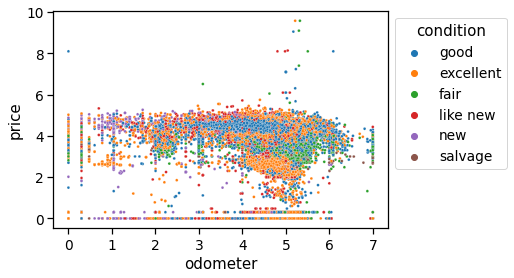

In [ ]:
ax = sns.scatterplot(data=df_result, x='odometer', y='price', hue='condition', s=8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Pie Chart

Lets see the percentage of each condition of cars in the dataset.

In [ ]:
df_result = spark.sql('SELECT condition FROM data')
df_result = df_result.toPandas()

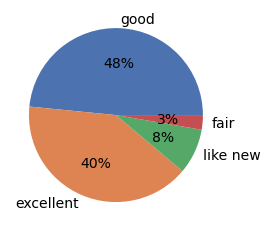

In [ ]:
df_result_c = df_result['condition'].value_counts().nlargest(4)
colors = sns.color_palette('deep')

plt.pie(df_result_c.values, labels=df_result_c.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

### Pairplot

Lets see how price, year, and odometer are correlated to each other

In [ ]:
df_result = spark.sql('SELECT condition, price, year, odometer FROM data')
df_result = df_result.toPandas()

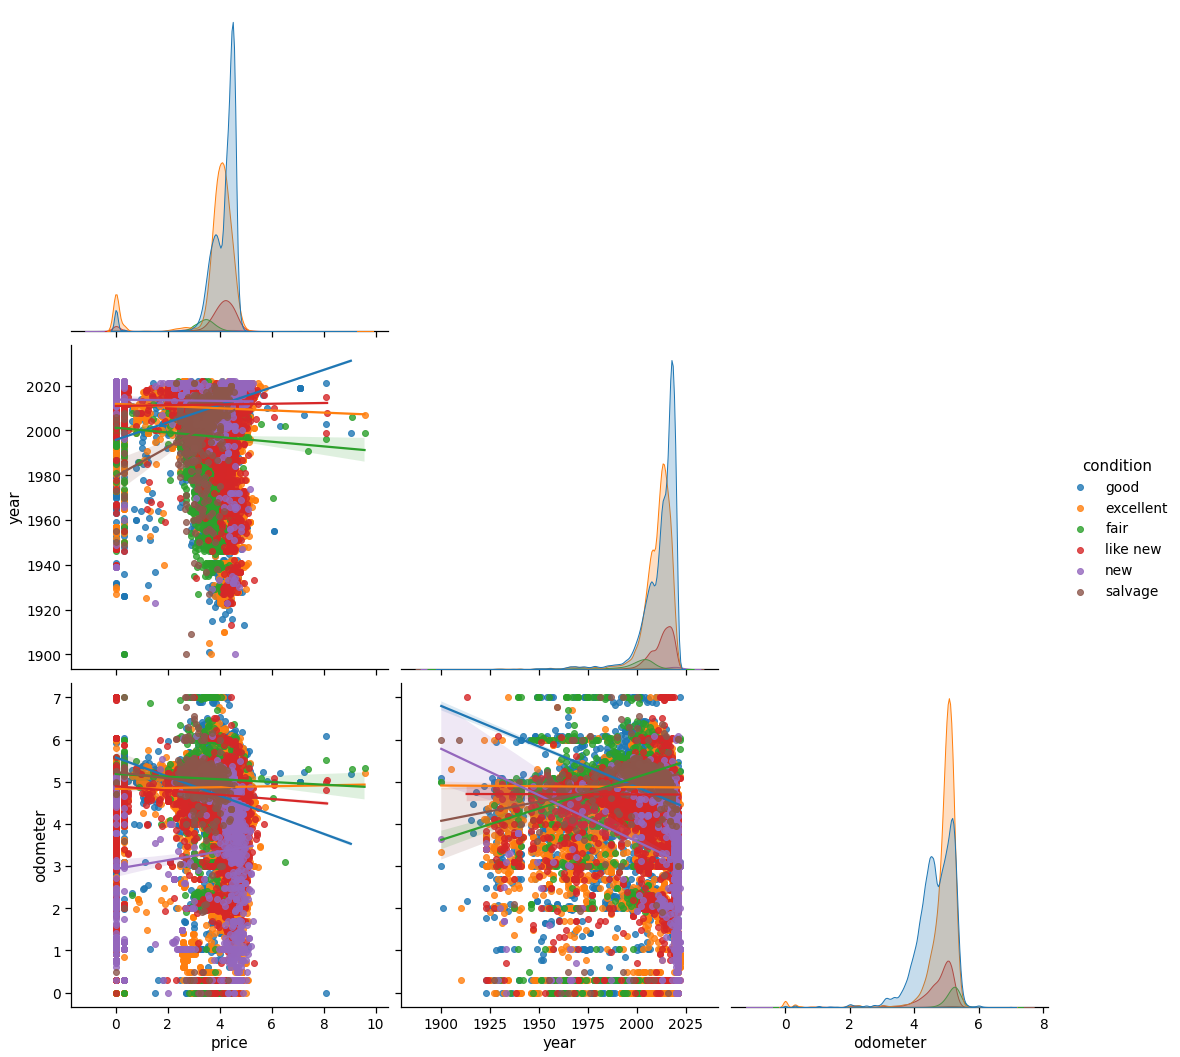

In [ ]:
sns.pairplot(df_result, kind='reg', hue='condition', corner=True, size=5)

Year vs Price (regression lines):
- Good condition -> Positively Strong Correlation: Newer and Pricier.
- Excellent condition -> Negatively Weak Correlation: Slightly older cars are Pricier. 
- Fair condition -> Negatively Weak Correlation: Slightly older cars are Pricier.
- Like New condition -> No Correlation: Year has no effect on Price.
- New condition -> No Correlation: Year has no effect on Price.
- Salvage condition -> Positively Strong Correlation: Newer and Pricier.

Odometer vs Price (regression lines):
- Good condition -> Negatively Strong Correlation: Less miles on Odometer make them Pricier.
- Excellent condition -> Positively Weak Correlation: Slightly more miles on Odometer make them slighlty Pricier. 
- Fair condition -> Negatively Weak Correlation: Less miles on Odometer make them slightly Pricier.
- Like New condition -> Negatively Weak Correlation: Less miles on Odometer make them slightly Pricier.
- New condition -> Positively Weak Correlation: Slightly more miles on Odometer make them slighlty Pricier. 
- Salvage condition -> Negatively Weak Correlation: Less miles on Odometer make them slightly Pricier.

Year vs Odometer (regression lines):
- Good condition -> Negatively Strong Correlation: Less miles on Odometer for newer (as in year) cars.
- Excellent condition -> Negatively Weak Correlation: Slightly less miles on slightly newer cars.
- Fair condition -> Positively Strong Correlation: More miles on newer cars.
- Like New condition -> No Correlation: Year does not affect the amount of miles on cars. 
- New condition -> Negatively Strong Correlation: Less miles on newer cars.
- Salvage condition -> Positively Weak Correlation: Slightly more miles on newer cars. 

## Data Preparation for ML

### Category Dropping
Some columns have too much categories, let's drop infrequent ones.

In [ ]:
cat_cols = ['region', 'manufacturer', 'model', 'condition', \
            'cylinders', 'fuel', 'title_status', 'transmission',\
           'VIN', 'drive', 'size', 'type', 'paint_color', 'county', 'state']

n = 32

for col in cat_cols:
    most_freq = data.groupBy(col).count().orderBy('count', ascending=False).take(n - 1)
    most_freq = spark.createDataFrame(most_freq).toPandas()
    most_freq = most_freq[col].tolist()

    data = data.withColumn(col, F.when(F.col(col).isin(most_freq), F.col(col)))

### Imputation

On Numeric Columns, we will replace the missing values using the mean of each column.

In [ ]:
num_cols = ['year', 'odometer', 'lat', 'long', 'posting_year', 'posting_month']

imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(data)
data = model.transform(data)

On Categorical Columns, we will replace the missing values with 'unknown'.

In [ ]:
data = data.fillna('unknown', subset=cat_cols)

Then we will encode all the categorical columns using StringIndexer and drop the original columns.

In [ ]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    data = indexer.fit(data).transform(data)
    
data = data.drop(*cat_cols)

### Combining Feature Columns

Inputs to Scikit-learn models have the data split into X-arrays/dataframes (features) and Y-arrays/dataframes (predictors). PySpark expects both the features and the predictor to be in a single dataframe. However, all the features have to be combined into a single column containing a list of the feature values. To accomplish this, we use [`VectorAssembler`](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler).

Note that VectorAssembler uses transform. This is just like the second step of Scikit-learn's feature transformers for normalization, etc.

In [ ]:
cols = data.columns
cols.remove('id') #remove id -> we simply do not need this
cols.remove('price') #remove price -> we need this to be our label

assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(data)

### Set columns and Split

Before modelling, the data are split into train and test data sets. We will make the train set bigger at this point as will incorporate cross validation later on.

In [ ]:
# We have created a new dataframe only consisting of the features column and the label column (actually price column but renamed)
df_data = data.select(F.col('features'), F.col('price').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

## Model Building


### Initialize Evaluator and Grid
As we are dealing with continuous values, we will be using Regressors to be trained on the data and then be used in prediction. Accordingly, we will have to use Regression Evaluator to evaluate all the Regressors we will be using.

In [ ]:
evaluator = RegressionEvaluator() # Can specify what metrics we want to use. Default metric is Root Mean Squared Error (RMSE)
grid = ParamGridBuilder().build()

### Initialize Regressors and Train

Now we get to the fun part--machine learning! 

PySpark has two machine learning libraries:

1. MLlib: older, based on RDDs, more complete, but no additional features are being added as of Spark 2.0
2. ML: the *future*, based on DataFrames, less feature complete than MLlib but this is improving

Often the name MLlib is used to refer to both libraries, so context is important and this can be confusing. We will be using ML whenever possible.

We will use Random Forest Regressor, Gradient Boosted Trees Regressor, Decision Tree Regressor, and Linear Regression. We will also be using cross validation as mentioned earlier with 5 folds (you can adjust this number).

We will begin by training a number of models and evaluating the results. Notice that the `fit` method is similar to Scikit-learn. However, `transform` is used with PySpark instead of `predict`. The syntax is similar among different PySpark ML models, though.

In [ ]:
#Random Forest Regressor
classifier_rf = RandomForestRegressor(featuresCol='features', labelCol='label')
cv_rf = CrossValidator(estimator=classifier_rf, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_rf = cv_rf.fit(df_train)

In [ ]:
#Gradient Boosted Tree Regressor
classifier_gbt = GBTRegressor(featuresCol="features", labelCol='label', maxIter=10)
cv_gbt = CrossValidator(estimator=classifier_gbt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_gbt = cv_gbt.fit(df_train)

In [ ]:
#Decision Tree Regressor
classifier_dt = DecisionTreeRegressor(featuresCol="features", labelCol='label')
cv_dt = CrossValidator(estimator=classifier_dt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_dt = cv_dt.fit(df_train)

In [ ]:
#Linear Regression
classifier_lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
cv_lr = CrossValidator(estimator=classifier_lr, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_lr = cv_lr.fit(df_train)

### Evaluation

We will now get the average metrics of all models created by the regressors in the last step. And we will use the best model from each of the cross validated regressors to make predictions on the testing set. Lastly, this will all be presented in a dataframe for us to compare.

In [ ]:
metrics = []
models = [cv_model_rf, cv_model_gbt, cv_model_dt, cv_model_lr]

for model in models:
    metrics.append(model.avgMetrics)
print (metrics)

for idx, model in enumerate(models): 
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='mae').evaluate(model.bestModel.transform(df_test)))

df = pd.DataFrame(metrics, index = ['Random Forest Regressor', 'Gradient Boosted Tree Regressor', 'Decision Tree Regressor', 'Linear Regression'], columns=['Average Metrics (CV)', 'Best Model R2 on Test Set', 'Best Model RMSE on Test Set', 'Best Model MAE on Test Set'])

df

For further reading on PySpark classification and regression follow this link: https://spark.apache.org/docs/latest/ml-classification-regression.html